In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import gc
color = sns.color_palette()

%matplotlib inline


from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

gc.enable()
features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source']
def load_df(csv_path='../input/train_v2.csv'):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                    chunksize = 100000)
    for df in dfs:
        df.reset_index(drop = True,inplace = True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis = 0).reset_index(drop = True)
        print(ans.shape)
    return ans


In [4]:
%%time

test_df = load_df("E:\\datasets\\google customer revenue new data\\all\\test_v2.csv")

Loaded test_v2.csv. Shape: (100000, 59)
(100000, 29)
Loaded test_v2.csv. Shape: (100000, 59)
(200000, 29)
Loaded test_v2.csv. Shape: (100000, 59)
(300000, 29)
Loaded test_v2.csv. Shape: (100000, 59)
(400000, 29)
Loaded test_v2.csv. Shape: (1589, 59)
(401589, 29)


NameError: name 'test' is not defined

In [5]:
test_df.shape

(401589, 29)

In [7]:
test_df.nunique()

channelGrouping                    8
date                             168
fullVisitorId                 296530
visitId                       393181
visitNumber                      386
visitStartTime                393643
device.browser                    62
device.deviceCategory              3
device.isMobile                    2
device.operatingSystem            22
geoNetwork.city                  503
geoNetwork.continent               6
geoNetwork.country               208
geoNetwork.metro                  82
geoNetwork.networkDomain       15934
geoNetwork.region                269
geoNetwork.subContinent           23
totals.bounces                     1
totals.hits                      208
totals.newVisits                   1
totals.pageviews                 155
totals.transactionRevenue       1950
trafficSource.adContent           28
trafficSource.campaign            26
trafficSource.isTrueDirect         1
trafficSource.keyword            677
trafficSource.medium               7
t

In [8]:
%%time
train_df = load_df("E:\\datasets\\google customer revenue new data\\all\\train_v2.csv")

Loaded train_v2.csv. Shape: (100000, 59)
(100000, 29)
Loaded train_v2.csv. Shape: (100000, 60)
(200000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(300000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(400000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(500000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(600000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(700000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(800000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(900000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(1000000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(1100000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(1200000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(1300000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(1400000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(1500000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(1600000, 29)
Loaded train_v2.csv. Shape: (100000, 59)
(1700000, 29)
Loaded train_v2.csv. Shape: (8337, 59)
(1708337, 29)
Wall time: 12min 57s


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 29 columns):
channelGrouping               object
date                          int64
fullVisitorId                 object
visitId                       int64
visitNumber                   int64
visitStartTime                int64
device.browser                object
device.deviceCategory         object
device.isMobile               bool
device.operatingSystem        object
geoNetwork.city               object
geoNetwork.continent          object
geoNetwork.country            object
geoNetwork.metro              object
geoNetwork.networkDomain      object
geoNetwork.region             object
geoNetwork.subContinent       object
totals.bounces                object
totals.hits                   object
totals.newVisits              object
totals.pageviews              object
totals.transactionRevenue     object
trafficSource.adContent       object
trafficSource.campaign        object
traff

In [11]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  18514  and ratio is :  0.010837440153786987
Number of unique customers with non-zero revenue :  16141 and the ratio is :  0.012193574218307359


In [12]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  1323730  out of rows :  1708337
Number of unique visitors in test set :  296530  out of rows :  401589
Number of common visitors in train and test set :  2759


# Missing value details

In [13]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    
    print("\n Total of Sales % of Total: ", round((data[data['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(data['totals.transactionRevenue']) * 100),4))
    
    return

In [15]:
missing_values(train_df)

Total columns at least one Values: 
                              Total    Percent
totals.transactionRevenue   1689823  98.916256
trafficSource.adContent     1643600  96.210525
trafficSource.isTrueDirect  1173819  68.711209
trafficSource.referralPath  1142073  66.852910
trafficSource.keyword       1052780  61.626014
totals.bounces               836759  48.980910
totals.newVisits             400907  23.467676
totals.pageviews                239   0.013990

 Total of Sales % of Total:  1.0837


# Drop columns which are not there in test set but present in train set

In [16]:
unwanted_col = set(train_df.columns).difference(set(test_df.columns))

In [17]:
unwanted_col

set()

##### already everything removed

# Check the distribution of traget variable (totals.transactionRevenue)


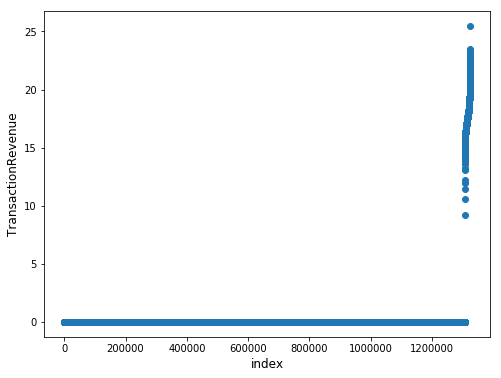

In [18]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
#plt.hist( gdf["totals.transactionRevenue"].values)
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

#### As Dataset description says 80/20 rule

#### only 20% of customers are responsible for 80% or total transactions

In [19]:
len(train_df)

1708337

In [21]:
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
nrc = gdf[gdf['totals.transactionRevenue']==0]
rc = gdf[gdf['totals.transactionRevenue']>0]
print("The number of nonrevenue customers are ", len(nrc))
print("The number of revenue generating customers are ", len(rc))
print("the ratio of revenue generating customers are {0:0.4}%".format(len(rc)/len(gdf)*100))

The number of nonrevenue customers are  1307589
The number of revenue generating customers are  16141
the ratio of revenue generating customers are 1.219%


In [22]:
train_df['totals.transactionRevenue'].fillna(0.0, inplace=True)

## If we only consider non zero transactionRevenue

In [23]:
nzr = train_df[train_df['totals.transactionRevenue']>0]['totals.transactionRevenue']

In [24]:
nzr.describe()

count    1.851400e+04
mean     1.251132e+08
std      4.162653e+08
min      1.000000e+04
25%      2.306750e+07
50%      4.606000e+07
75%      1.000000e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

E:\anaconda_installed\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


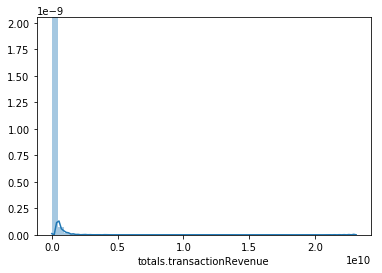

In [25]:
sns.distplot(nzr)

#### distribution is not normal and also submission must be done in log format so better transform it

In [28]:
log_revenue = train_df["totals.transactionRevenue"].apply(np.log1p)

In [29]:
log_revenue[log_revenue>0].head()

433    16.536148
550    15.894952
555    17.863811
597    16.718579
619    16.325923
Name: totals.transactionRevenue, dtype: float64

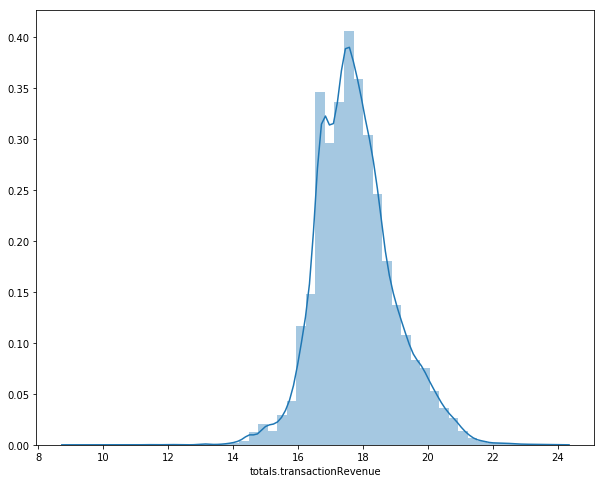

In [30]:
plt.figure(figsize=(10,8))
nzr = log_revenue[log_revenue>0]
sns.distplot(nzr)

In [31]:
from scipy.stats import kurtosis, skew
total = nzr
print("The skewness of the transaction value ", skew(total))
print("The kurtosis of the transaction value ", kurtosis(total))

The skewness of the transaction value  0.3809221371038405
The kurtosis of the transaction value  1.0575313763811511


#### skewness if just 0.3, so it is almost symmetrical
#### kurtosis is more than 1 shows that it is little sharp and not a perfect bell shaped curve

## feature engineering of Date column and  visitStartTime

In [32]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,0.0,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,0.0,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,0.0,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google


In [33]:
# library of datetime
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [34]:
train_df = date_process(train_df)
test_df = date_process(test_df)

In [35]:
train_copy = train_df.copy()
test_copy = test_df.copy()

## Exploring Date column

E:\anaconda_installed\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


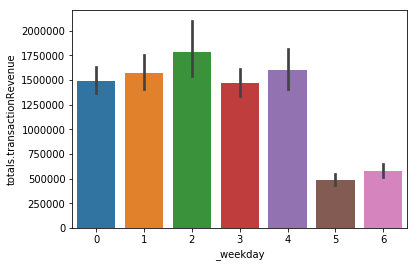

In [36]:
sns.barplot(x=train_df['_weekday'], y=train_df['totals.transactionRevenue'], data=train_df)

##### <i>Weeak day 0 is Monday
##### <i>weekdays we can expect more sales
##### <i>in weekend sales are less 

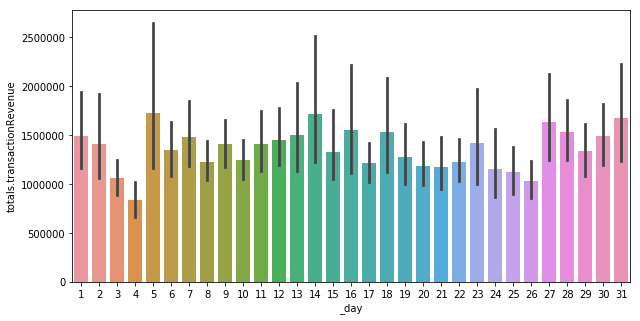

In [37]:
%matplotlib inline
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['_day'], y=train_df['totals.transactionRevenue'], data=train_df)

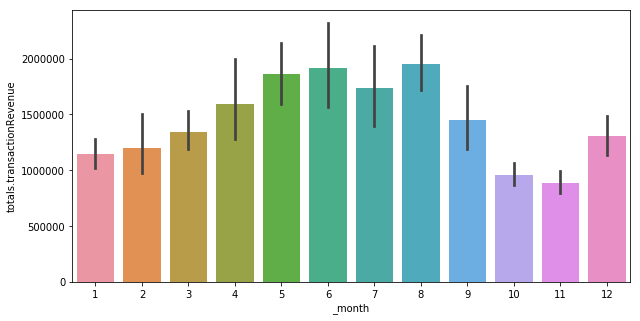

In [38]:
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['_month'], y=train_df['totals.transactionRevenue'], data=train_df)

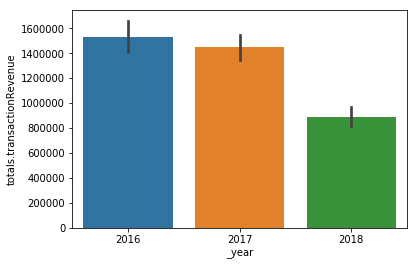

In [39]:
sns.barplot(x=train_df['_year'], y=train_df['totals.transactionRevenue'], data=train_df)

In [43]:
train_df['date'].describe()

count                 1708337
unique                    638
top       2017-12-12 00:00:00
freq                     9234
first     2016-08-01 00:00:00
last      2018-04-30 00:00:00
Name: date, dtype: object

In [44]:
test_df['date'].describe()

count                  401589
unique                    168
top       2018-05-10 00:00:00
freq                     3884
first     2018-05-01 00:00:00
last      2018-10-15 00:00:00
Name: date, dtype: object

###### train set consists of data from 1st August 2016   to   30th April 2018
######  test set consists of data from  1st May 2018 to  15th october 2018

E:\anaconda_installed\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


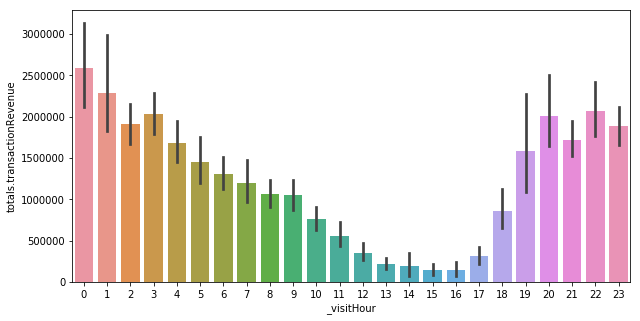

In [45]:
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['_visitHour'], y=train_df['totals.transactionRevenue'], data=train_df)

##### night 7 to morning 9 ,revenue generation is high  
####  afternoon time , revenue generation is very less

# Date v/s  transactionRevenue

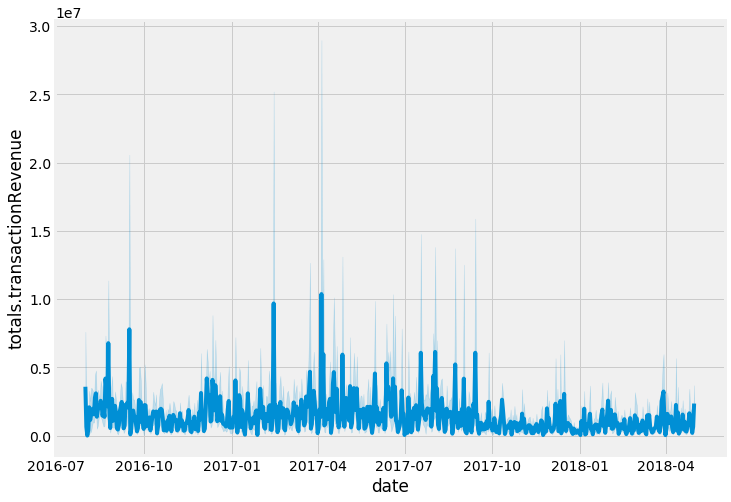

In [46]:
plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')
sns.lineplot(train_df['date'], train_df['totals.transactionRevenue'])

## Date v/s userCounts  in train set

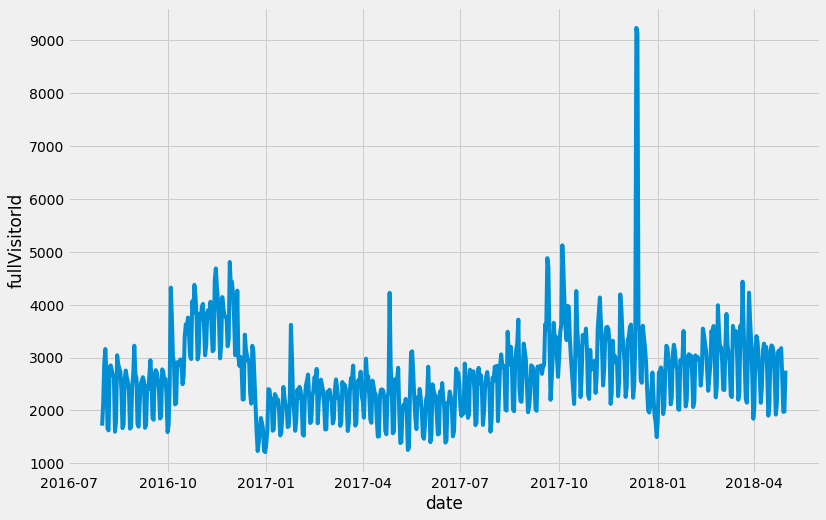

In [47]:
cnt_srs = train_df.groupby('date')['fullVisitorId'].size().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(cnt_srs['date'], cnt_srs['fullVisitorId'])

##### huge spike(customers) visited google store from november 2017 to december 2017

## Date v/s userCounts in Test set

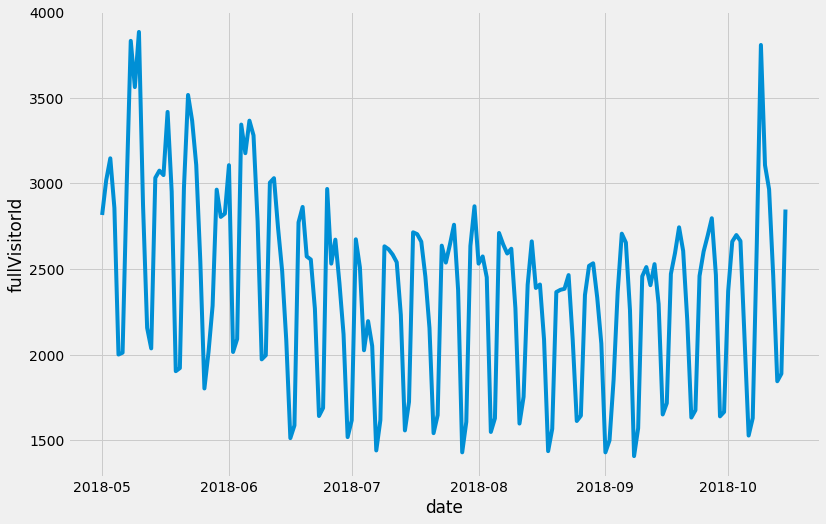

In [48]:
cnt_srs = test_df.groupby('date')['fullVisitorId'].size().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(cnt_srs['date'], cnt_srs['fullVisitorId'])

##### number of customers are reduced

In [49]:
test_df.nunique()

channelGrouping                    8
date                             168
fullVisitorId                 296530
visitId                       393181
visitNumber                      386
visitStartTime                393643
device.browser                    62
device.deviceCategory              3
device.isMobile                    2
device.operatingSystem            22
geoNetwork.city                  503
geoNetwork.continent               6
geoNetwork.country               208
geoNetwork.metro                  82
geoNetwork.networkDomain       15934
geoNetwork.region                269
geoNetwork.subContinent           23
totals.bounces                     1
totals.hits                      208
totals.newVisits                   1
totals.pageviews                 155
totals.transactionRevenue       1950
trafficSource.adContent           28
trafficSource.campaign            26
trafficSource.isTrueDirect         1
trafficSource.keyword            677
trafficSource.medium               7
t

# EDA

### function to exctract columns of specific category

In [50]:
import re
def columns_extract(category):
    cat_cols = list()
    for i in train_df.columns: 
        a = re.findall(r'^'+category+'.*',i)
        if a:
            cat_cols.append(a[0])
        else:
            continue
    return cat_cols

### function to plot specific attributes

In [55]:
def category_plots(col):
    a = train_df.loc[:,[col, 'totals.transactionRevenue']]
    a['totals.transactionRevenue'] = a['totals.transactionRevenue'].replace(0.0, np.nan)
    #a['totals.transactionRevenue'] = a['totals.transactionRevenue'].apply(np.expm1)
    cnt_srs = a.groupby(col)['totals.transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count of non-zero revenue', "mean transaction value"]

    cnt_srs['total_revenue'] = cnt_srs['count of non-zero revenue']*cnt_srs['mean transaction value']
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    print(cnt_srs.head(10))
    plt.figure(figsize=(8, 20)) 
    plt.subplot(4,1,1)
    sns.barplot(x=cnt_srs['count'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,2)
    sns.barplot(x=cnt_srs['count of non-zero revenue'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,3)
    sns.barplot(x=cnt_srs['mean transaction value'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,4)
    sns.barplot(x=cnt_srs['total_revenue'].head(10), y=cnt_srs.index[:10])

#cnt_srs

## Exploring Device attributes

In [56]:
device_cols = columns_extract('device')

In [57]:
train_df[device_cols].nunique(dropna=False)

device.browser            129
device.deviceCategory       3
device.isMobile             2
device.operatingSystem     24
dtype: int64

##### explorable columns   'device.browser',  'device.deviceCategory',  'device.operatingSystem '

<b>device.browser

                     count  count of non-zero revenue  mean transaction value  \
device.browser                                                                  
Chrome             1173056                      16697            1.238645e+08   
Safari              312165                       1210            6.338925e+07   
Firefox              63845                        339            4.432043e+08   
Internet Explorer    35474                        148            8.079703e+07   
Android Webview      34266                         10            1.861100e+07   
Edge                 20543                         74            1.090176e+08   
Samsung Internet     15792                          8            2.760625e+07   
Opera Mini           15018                          0                     NaN   
Safari (in-app)      14207                         12            1.281417e+07   
Opera                 9585                         14            4.248357e+07   

                   total_re

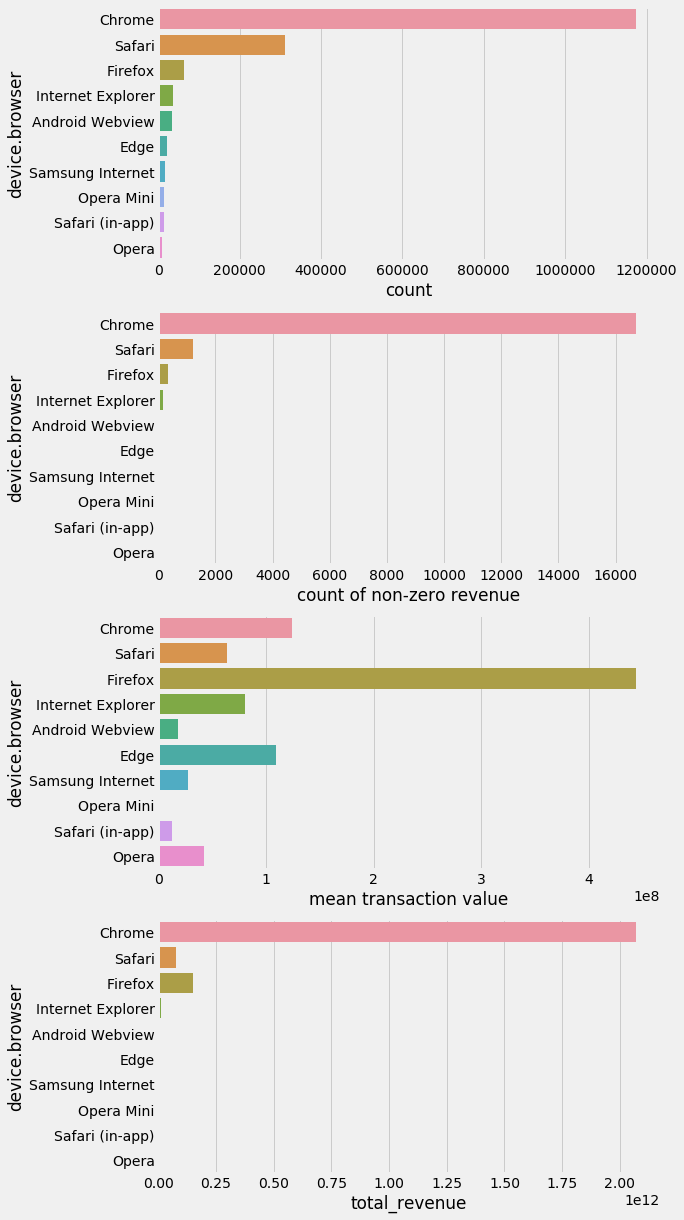

In [58]:
category_plots('device.browser')

###### though safari users are more , revenue generating customers are less
###### firefox users generate a more mean value
###### only chrome users are major source of revenue generation

### -----------------------------------------------------------------------------------------------------------------------------

<b> device.deviceCategory

                         count  count of non-zero revenue  \
device.deviceCategory                                       
desktop                1171579                      16905   
mobile                  471336                       1364   
tablet                   65422                        245   

                       mean transaction value  total_revenue  
device.deviceCategory                                         
desktop                          1.318602e+08   2.229097e+12  
mobile                           5.447116e+07   7.429866e+10  
tablet                           5.285339e+07   1.294908e+10  


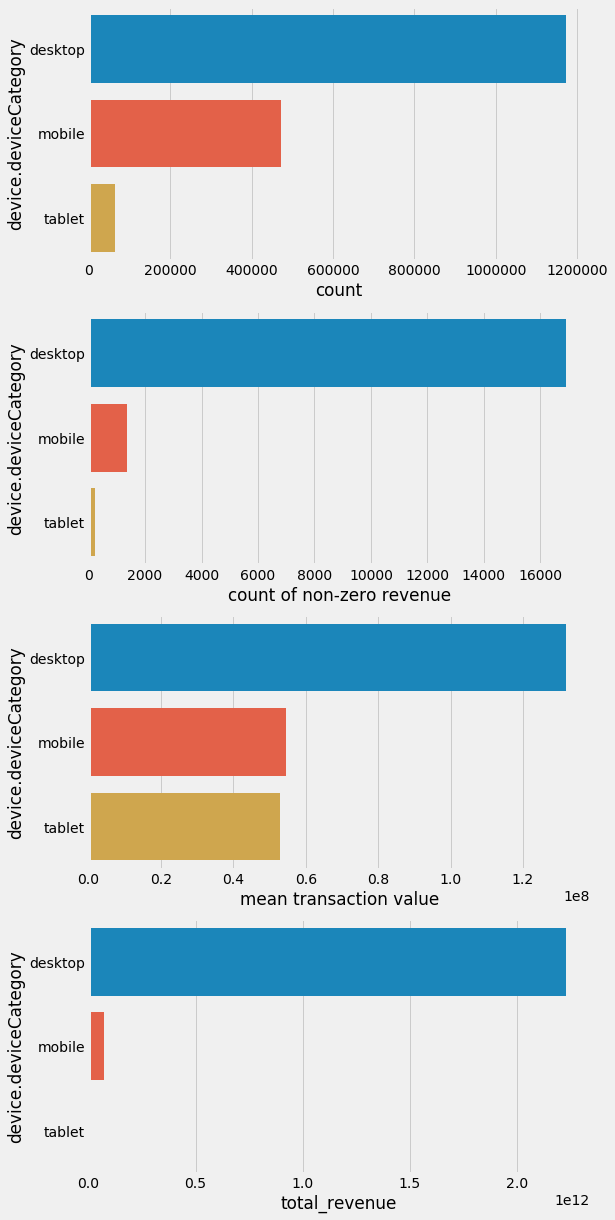

In [59]:
category_plots('device.deviceCategory')

##### Desktop users generate more revenue

##### ----------------------------------------------------------------------------------------------------------------

###### device.operatingSystem

                         count  count of non-zero revenue  \
device.operatingSystem                                      
Windows                 619720                       3571   
Macintosh               438514                      10354   
Android                 299386                        753   
iOS                     219334                        832   
Linux                    63971                       1300   
Chrome OS                51318                       1703   
(not set)                11815                          0   
Windows Phone             1675                          1   
Samsung                    911                          0   
Tizen                      709                          0   

                        mean transaction value  total_revenue  
device.operatingSystem                                         
Windows                           1.610381e+08   5.750670e+11  
Macintosh                         1.270264e+08   1.315231e+12  
Android    

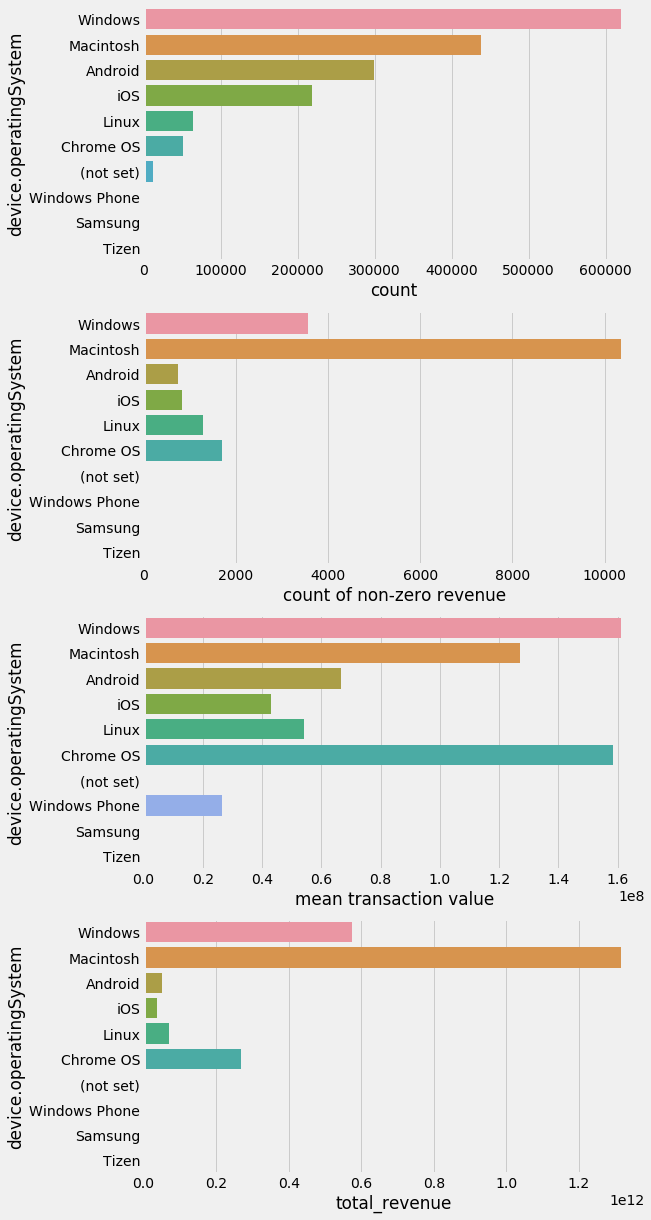

In [60]:
category_plots('device.operatingSystem')

###### windows users are more 
###### revenue generating users are more in Mac category
###### mean revenue of chromse OS is high
###### definitely MAC, windows, chrome OS users are source of revenue generation

## Exploring Geonetwork category

In [61]:
geo_clos = columns_extract('geoNetwork')

In [62]:
train_df[geo_clos].nunique(dropna=False)

geoNetwork.city               956
geoNetwork.continent            6
geoNetwork.country            228
geoNetwork.metro              123
geoNetwork.networkDomain    41982
geoNetwork.region             483
geoNetwork.subContinent        23
dtype: int64

###### explorable columns are   geoNetwork.continent,   geoNetwork.country,     geoNetwork.subContinent ,   geoNetwork.networkDomain

######  geoNetwork.continent

                       count  count of non-zero revenue  \
geoNetwork.continent                                      
Americas              877403                      18150   
Asia                  396719                        190   
Europe                368037                        126   
Africa                 35481                         12   
Oceania                28180                         29   
(not set)               2517                          7   

                      mean transaction value  total_revenue  
geoNetwork.continent                                         
Americas                        1.247988e+08   2.265098e+12  
Asia                            1.231459e+08   2.339772e+10  
Europe                          8.926548e+07   1.124745e+10  
Africa                          7.521658e+08   9.025990e+09  
Oceania                         2.338310e+08   6.781100e+09  
(not set)                       1.136029e+08   7.952200e+08  


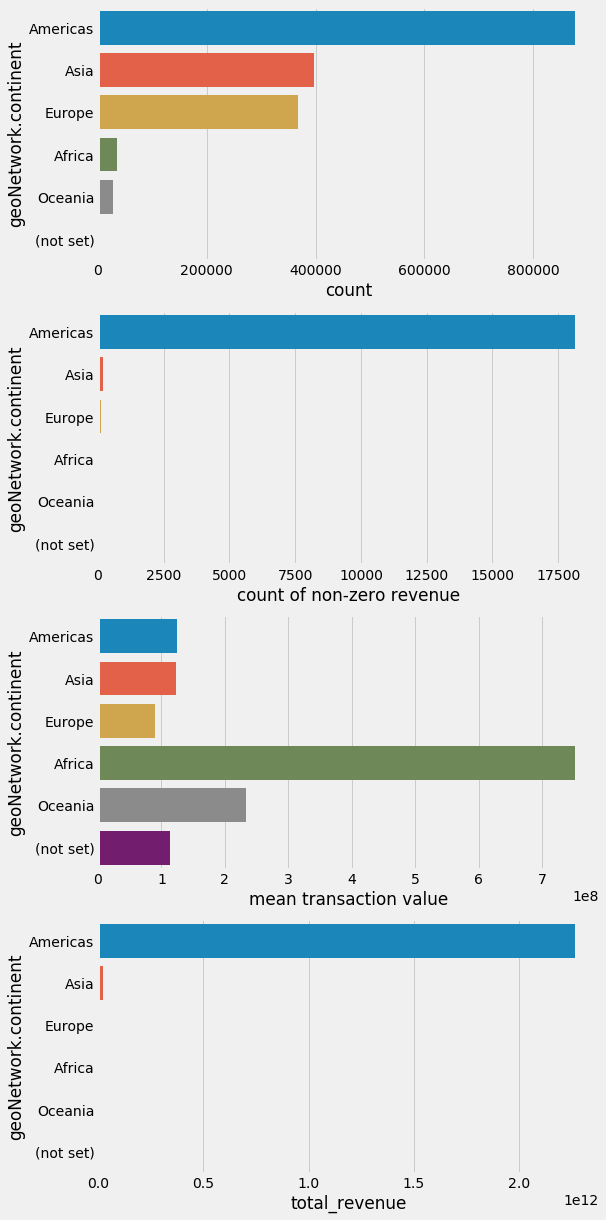

In [63]:
category_plots('geoNetwork.continent')

###### though Asia and Europe has descent number of users,   revenue generating users almost NIL
###### Africa has remarkably large mean value
###### Absolutely Americans are the major source of revenue generation

###### -----------------------------------------------------------------------------------------

#### geoNetwork.country

                     count  count of non-zero revenue  mean transaction value  \
geoNetwork.country                                                              
United States       717217                      17658            1.244697e+08   
India               105317                         18            7.425056e+07   
United Kingdom       73341                         25            9.900160e+07   
Canada               51057                        315            1.355531e+08   
Germany              38516                         12            6.402000e+07   
Japan                36637                         22            3.346136e+08   
Brazil               35432                         21            9.631952e+07   
Vietnam              34869                          0                     NaN   
France               32289                         11            9.733545e+07   
Thailand             29859                         10            6.141600e+07   

                    total_r

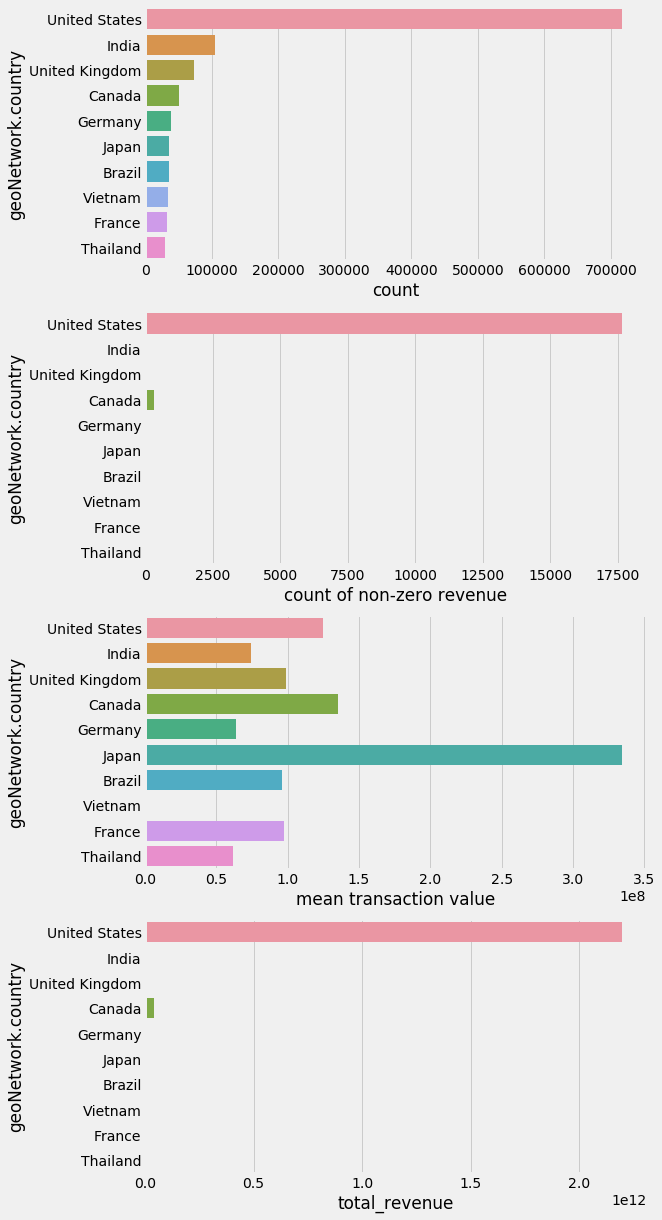

In [64]:
category_plots('geoNetwork.country')

###### Except North America other subcontinents has countable number of revenue generating customers
###### North America is the clear winner in generating revenue generation

###### ------------------------------------------------------------------------------

##### geoNetwork.subContinent

                          count  count of non-zero revenue  \
geoNetwork.subContinent                                      
Northern America         768345                      17973   
Southeast Asia           121634                         59   
Southern Asia            121062                         21   
Western Europe           115153                         48   
Northern Europe          111693                         43   
Eastern Asia              91072                         83   
South America             75112                        122   
Eastern Europe            74007                         22   
Southern Europe           67184                         13   
Western Asia              60966                         25   

                         mean transaction value  total_revenue  
geoNetwork.subContinent                                         
Northern America                   1.246639e+08   2.240584e+12  
Southeast Asia                     1.020234e+08   6.019380e+

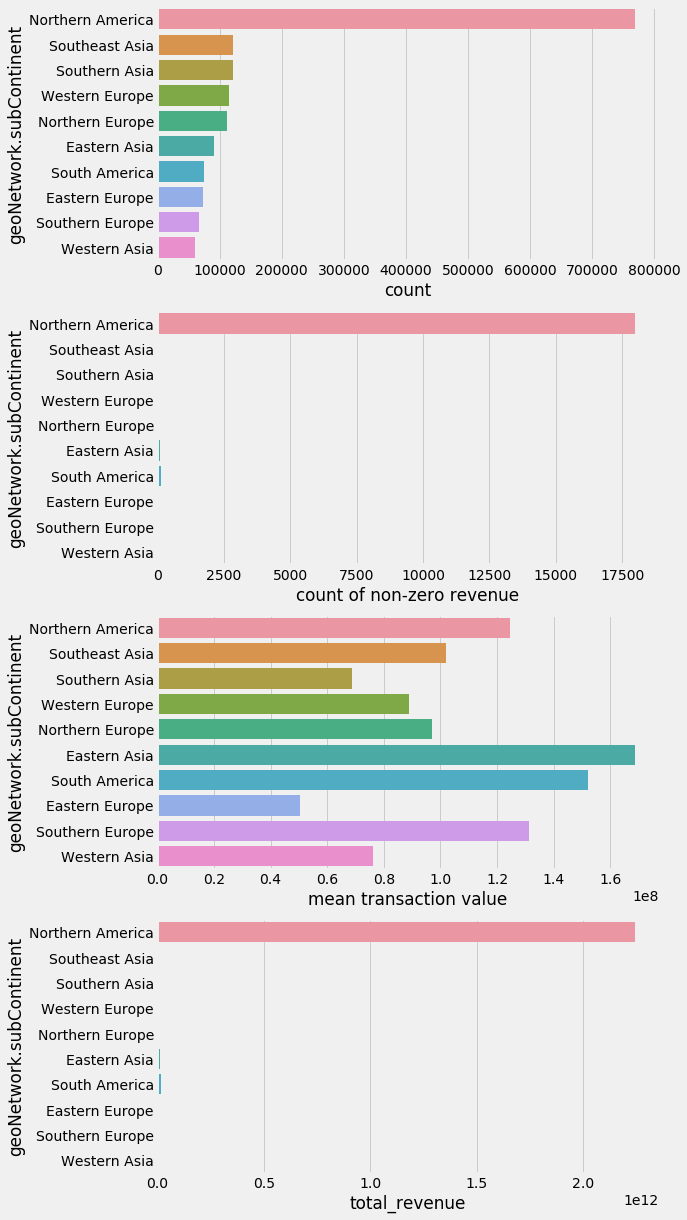

In [65]:
category_plots('geoNetwork.subContinent')

####  geoNetwork.networkDomain

                           count  count of non-zero revenue  \
geoNetwork.networkDomain                                      
(not set)                 499049                      10867   
unknown.unknown           269796                        665   
comcast.net                55486                       1505   
rr.com                     28715                        588   
verizon.net                26547                        755   
ttnet.com.tr               17078                          1   
comcastbusiness.net        16826                        454   
hinet.net                  15933                         17   
virginm.net                12594                          1   
cox.net                    10722                        236   

                          mean transaction value  total_revenue  
geoNetwork.networkDomain                                         
(not set)                           1.201659e+08   1.305843e+12  
unknown.unknown                     8.759997e

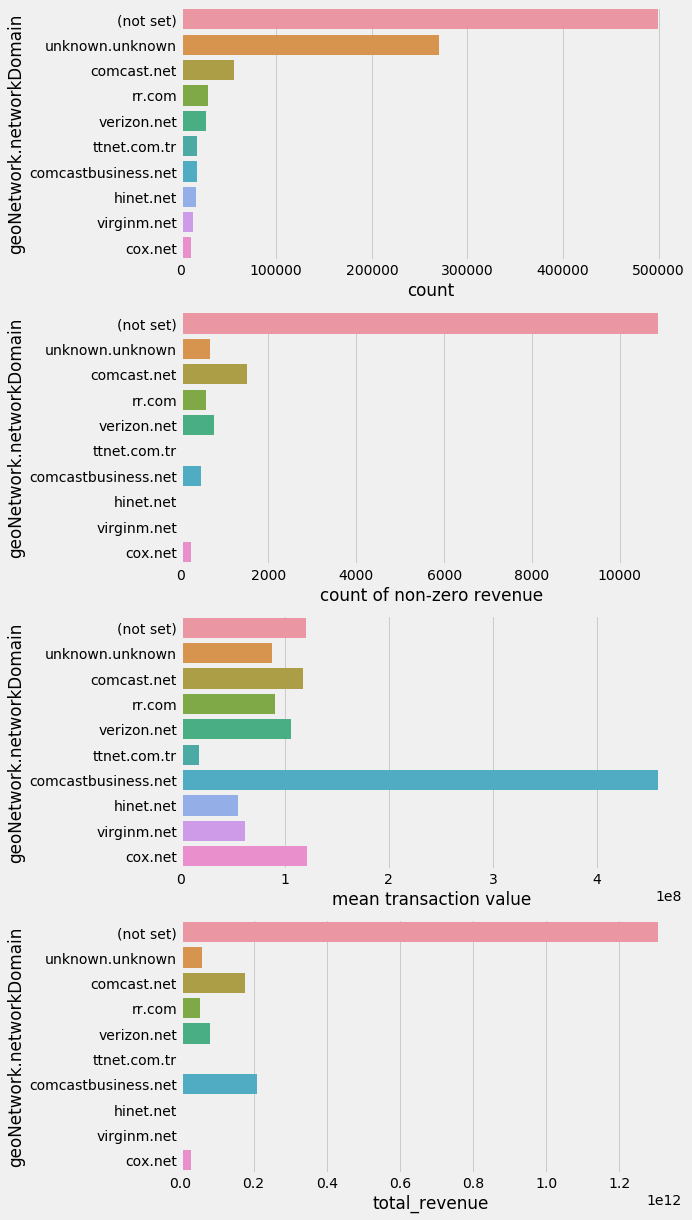

In [66]:
category_plots('geoNetwork.networkDomain')

##  Exploring traffic Source category

In [67]:
traffic_cols = columns_extract('trafficSource')

In [68]:
train_df[traffic_cols].nunique(dropna=False)

trafficSource.adContent         77
trafficSource.campaign          33
trafficSource.isTrueDirect       2
trafficSource.keyword         4547
trafficSource.medium             7
trafficSource.referralPath    3197
trafficSource.source           345
dtype: int64

##### explorable columns are    trafficSource.source,     trafficSource.referralPath,      trafficSource.medium

#####  trafficSource.source

                       count  count of non-zero revenue  \
trafficSource.source                                      
google                658384                       4683   
(direct)              565975                      13144   
youtube.com           329450                         25   
analytics.google.com   37436                          3   
Partners               32931                         17   
sites.google.com        9072                         76   
google.com              8341                         14   
m.facebook.com          6737                          7   
dfa                     6704                        137   
baidu                   4971                          0   

                      mean transaction value  total_revenue  
trafficSource.source                                         
google                          1.001894e+08   4.691871e+11  
(direct)                        1.282169e+08   1.685283e+12  
youtube.com                     2.337640e+0

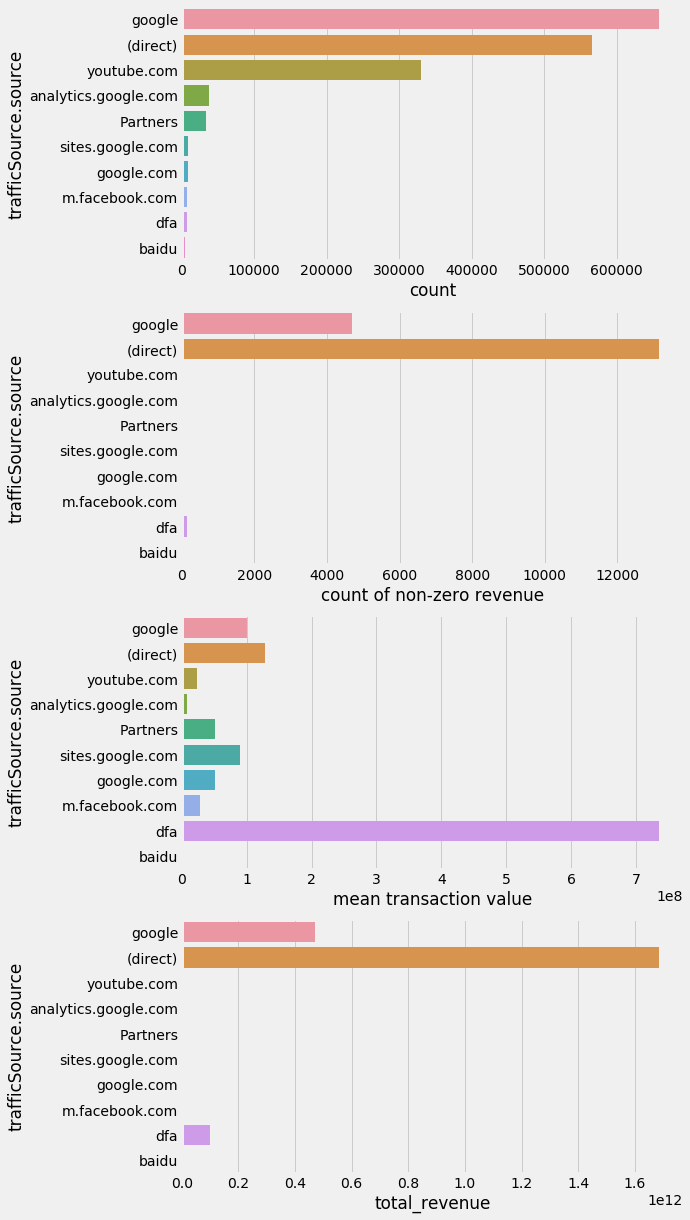

In [69]:
category_plots('trafficSource.source')

###### though Youtube has high number of counts in the dataset, the number of non-zero revenue counts are very less.
######  revenue generating customers are more in mall.googleplex.com
###### dfa has highest mean transaction value
###### mall.googleplex.com generates more revenue

###### ---------------------------------------------------------------------------------------------------

##### trafficSource.medium

                       count  count of non-zero revenue  \
trafficSource.medium                                      
organic               591783                       4196   
(none)                565957                      13144   
referral              432963                        468   
cpc                    75603                        490   
affiliate              32915                         17   
cpm                     8982                        198   
(not set)                134                          1   

                      mean transaction value  total_revenue  
trafficSource.medium                                         
organic                         9.962047e+07   4.180075e+11  
(none)                          1.282169e+08   1.685283e+12  
referral                        1.183178e+08   5.537271e+10  
cpc                             9.941222e+07   4.871199e+10  
affiliate                       5.088647e+07   8.650700e+08  
cpm                             5.

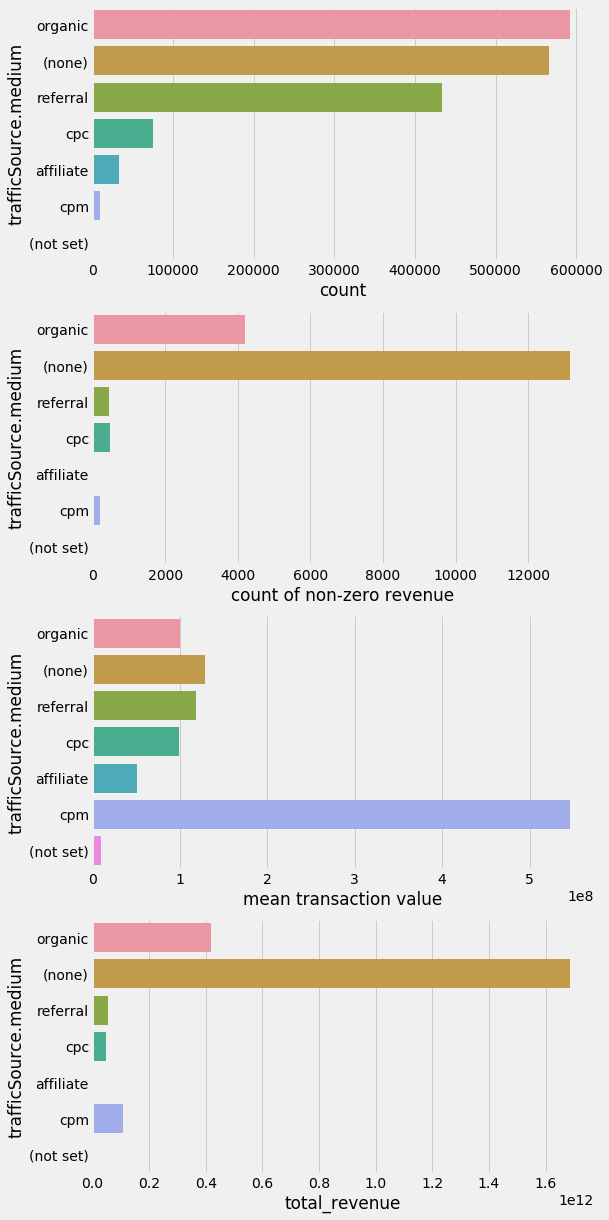

In [70]:
category_plots('trafficSource.medium')

###### On the traffic source medium, "referral" has more number of non-zero revenue count compared to "organic" medium.

### Most Ad Content

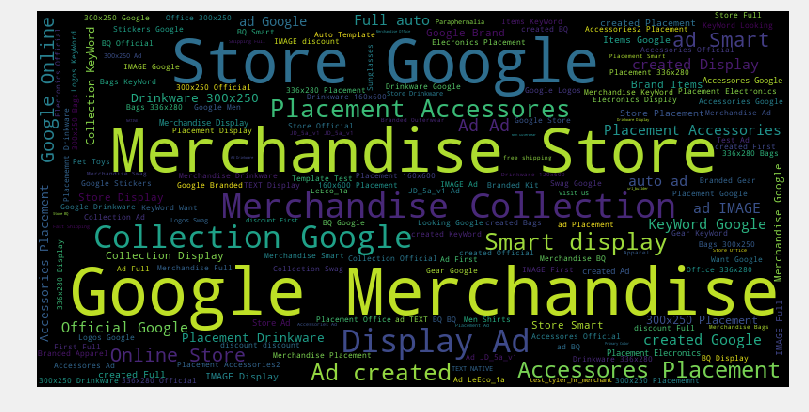

In [73]:
from wordcloud import WordCloud

ad_content = train_df['trafficSource.adContent'].fillna('')
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(ad_content))
plt.figure( figsize=(12,9))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

###  from which source  users visiting? 

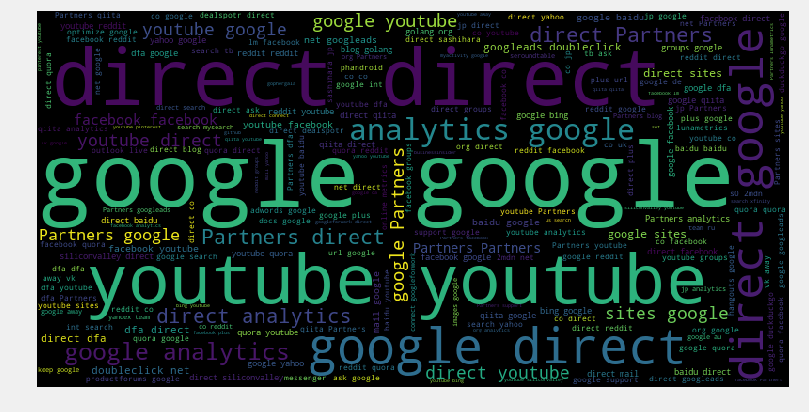

In [75]:
source = train_df['trafficSource.source'].fillna('')
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(source))
plt.figure( figsize=(12,10) )
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

##### ---------------------------------------------------------------------------

## Exploring totals  category

In [88]:
total_cols = columns_extract('totals')

In [89]:
train_df[total_cols].nunique(dropna=False)

totals.bounces                  2
totals.hits                   297
totals.newVisits                2
totals.pageviews              231
totals.transactionRevenue    7252
dtype: int64

### explorable columns are  totals.hits, totals.pageviews

In [93]:
def total_col_plots(col):
    a = train_df.loc[:,[col, 'totals.transactionRevenue']]
    a['totals.transactionRevenue'] = a['totals.transactionRevenue'].replace(0.0, np.nan)
    #a['totals.transactionRevenue'] = a['totals.transactionRevenue'].apply(np.expm1)
    cnt_srs = a.groupby(col)['totals.transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count of non-zero revenue', "mean"]

    cnt_srs['total_revenue'] = cnt_srs['count of non-zero revenue']*cnt_srs['mean']
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    print(cnt_srs.head(10))
    plt.figure(figsize=(15, 20)) 
    plt.subplot(4,1,1)
    sns.barplot(y=cnt_srs['count'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,2)
    sns.barplot(y=cnt_srs['count of non-zero revenue'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,3)
    sns.barplot(y=cnt_srs['mean'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,4)
    sns.barplot(y=cnt_srs['total_revenue'].head(50), x=list(range(1,51)))

#cnt_srs

              count  count of non-zero revenue          mean  total_revenue
totals.hits                                                                
1            864064                          0           NaN            NaN
2            237499                          7  2.201214e+08   1.540850e+09
3            134435                          6  7.817833e+07   4.690700e+08
4             80875                         15  8.806667e+07   1.321000e+09
5             63687                         27  1.187667e+08   3.206700e+09
6             46598                         26  3.551731e+07   9.234500e+08
7             38137                         54  5.201111e+07   2.808600e+09
8             29717                        107  7.241710e+07   7.748630e+09
9             24999                        166  9.122886e+07   1.514399e+10
10            20306                        231  9.973732e+07   2.303932e+10


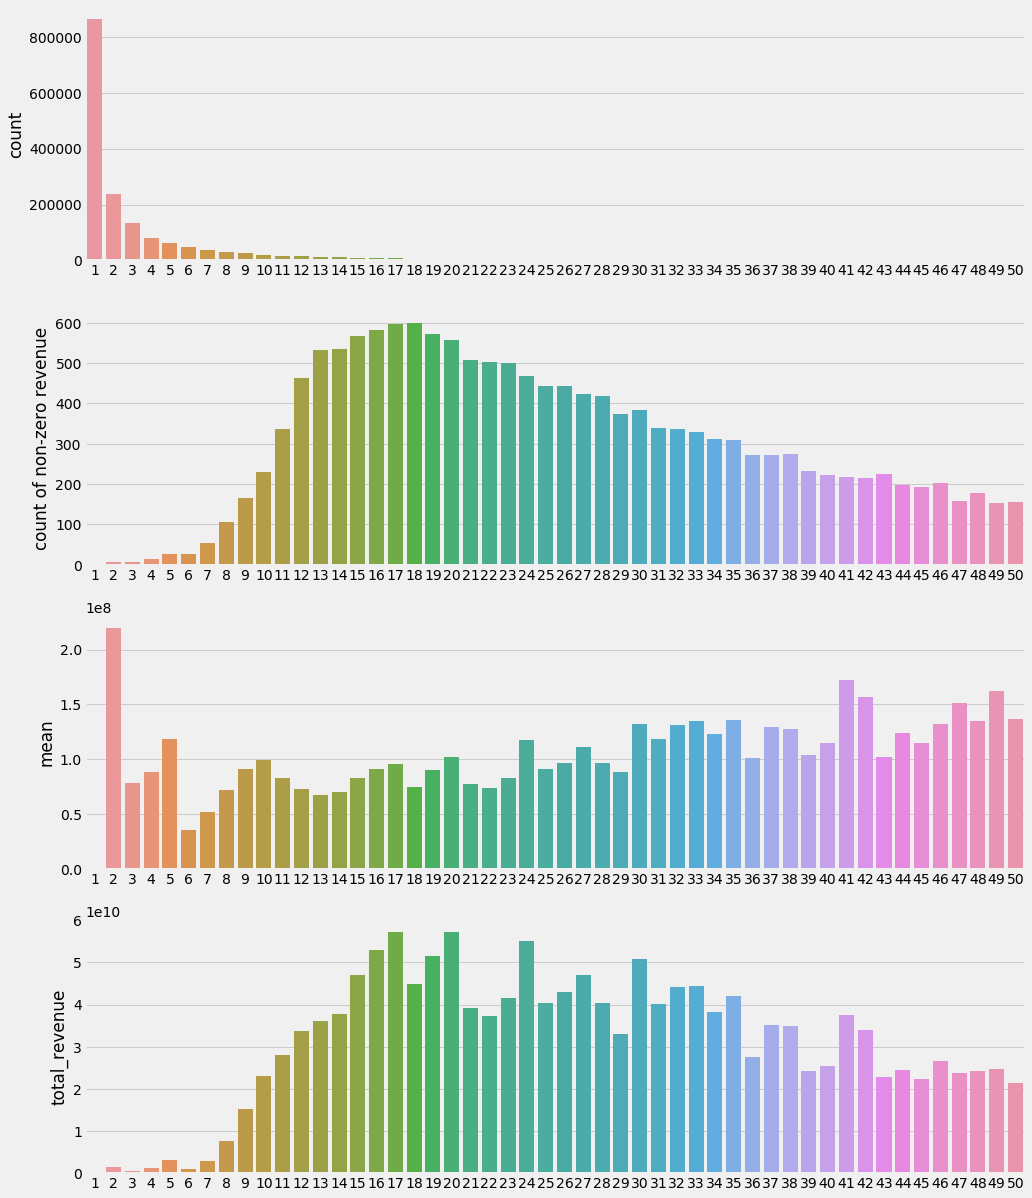

In [94]:
total_col_plots('totals.hits')

                   count  count of non-zero revenue          mean  \
totals.pageviews                                                    
1                 876328                          0           NaN   
2                 249794                          7  2.201214e+08   
3                 142896                          6  7.817833e+07   
4                  86666                         16  8.841688e+07   
5                  64712                         33  1.123712e+08   
6                  47721                         47  4.052234e+07   
7                  37751                         94  4.390862e+07   
8                  29586                        190  8.269163e+07   
9                  24153                        306  8.530141e+07   
10                 19228                        463  7.950987e+07   

                  total_revenue  
totals.pageviews                 
1                           NaN  
2                  1.540850e+09  
3                  4.690700e+08  
4

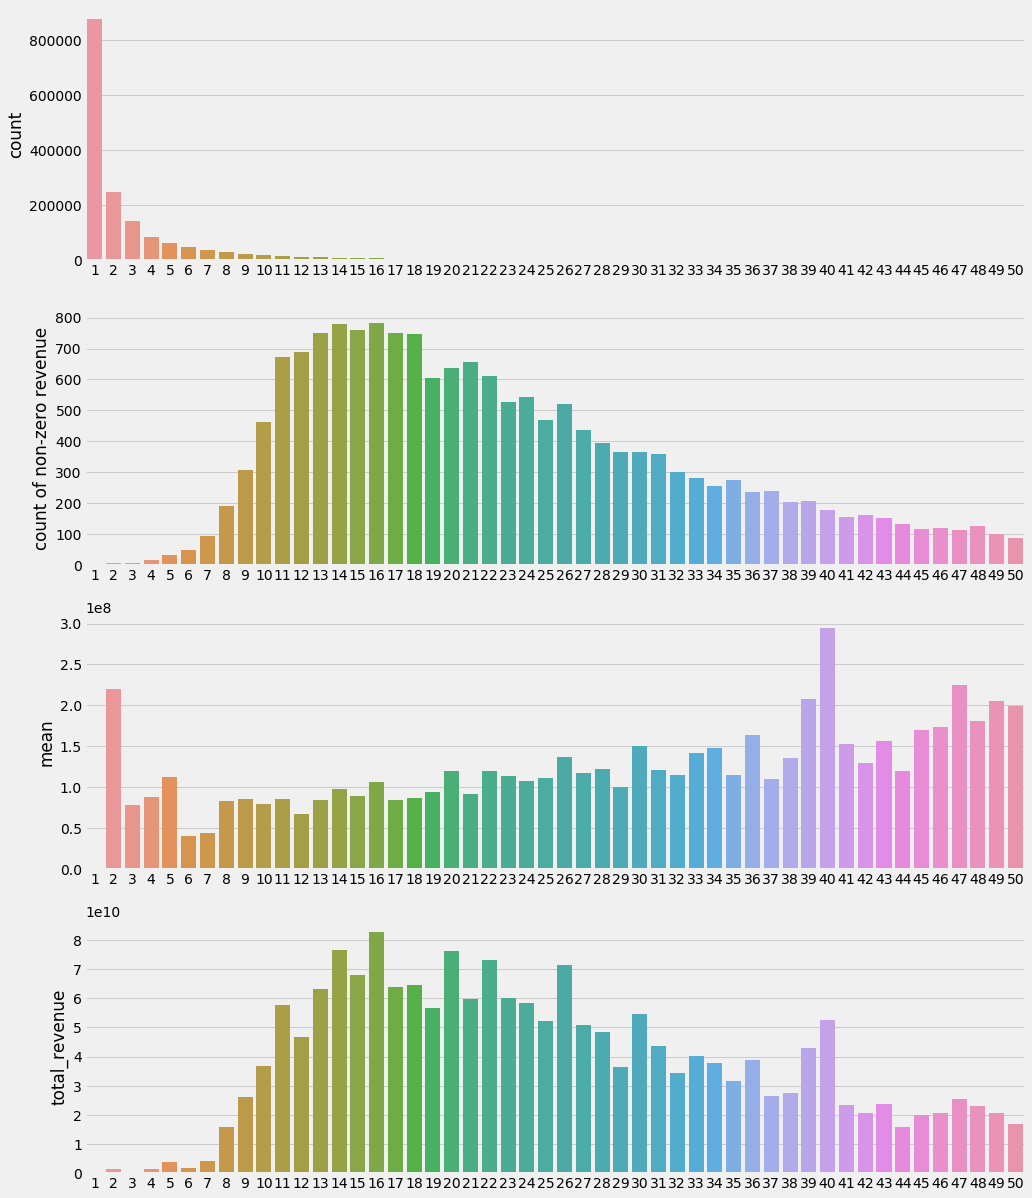

In [95]:
total_col_plots('totals.pageviews')

###### both plots looks similar
######  when the pagehits increases , revenue generation increase

###### categorical columns

In [96]:
train_df.dtypes

channelGrouping                       object
date                          datetime64[ns]
fullVisitorId                         object
visitId                                int64
visitNumber                            int64
visitStartTime                         int64
device.browser                        object
device.deviceCategory                 object
device.isMobile                         bool
device.operatingSystem                object
geoNetwork.city                       object
geoNetwork.continent                  object
geoNetwork.country                    object
geoNetwork.metro                      object
geoNetwork.networkDomain              object
geoNetwork.region                     object
geoNetwork.subContinent               object
totals.bounces                        object
totals.hits                           object
totals.newVisits                      object
totals.pageviews                      object
totals.transactionRevenue            float64
trafficSou

In [97]:
categorical_cols = list()
for i in train_df.columns:
    if train_df[i].dtype=='object' and (not(i.startswith('total'))):
        categorical_cols.append(i)

In [99]:
len(categorical_cols)

19

In [100]:
train_df[categorical_cols].nunique(dropna=False)

channelGrouping                     8
fullVisitorId                 1323730
device.browser                    129
device.deviceCategory               3
device.operatingSystem             24
geoNetwork.city                   956
geoNetwork.continent                6
geoNetwork.country                228
geoNetwork.metro                  123
geoNetwork.networkDomain        41982
geoNetwork.region                 483
geoNetwork.subContinent            23
trafficSource.adContent            77
trafficSource.campaign             33
trafficSource.isTrueDirect          2
trafficSource.keyword            4547
trafficSource.medium                7
trafficSource.referralPath       3197
trafficSource.source              345
dtype: int64

###### better remove fullVisitorId from categorical_cols to avoid label encoding of fullvisitorId

In [101]:
categorical_cols.remove('fullVisitorId')

###### since device.isMobile is of bool type we need to encode it so add this coloumn to categorical_cols

In [102]:
categorical_cols.append('device.isMobile')

#### numerical coloumns

In [104]:
numerical_cols = list()
for i in train_df.columns:
    if train_df[i].dtype not in ['object', 'bool']:
        numerical_cols.append(i)

In [105]:
numerical_cols

['date',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'totals.transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_year',
 '_visitHour']

In [106]:
numerical_cols.remove('date')
numerical_cols.remove('visitId')
numerical_cols.remove('visitStartTime')
numerical_cols.remove('_year')

In [107]:
numerical_cols

['visitNumber',
 'totals.transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_visitHour']

In [108]:
len(numerical_cols) + len(categorical_cols)

25

In [109]:
set(train_df.columns)-set(numerical_cols + categorical_cols)

{'_year',
 'date',
 'fullVisitorId',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'visitId',
 'visitStartTime'}

In [110]:
numerical_cols.append('totals.bounces')
numerical_cols.append('totals.hits')
numerical_cols.append('totals.newVisits')
numerical_cols.append('totals.pageviews')

In [111]:
numerical_cols

['visitNumber',
 'totals.transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_visitHour',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews']

## missing value treatment of numerical cols

In [113]:
train_df[numerical_cols].isnull().sum()

visitNumber                       0
totals.transactionRevenue         0
_weekday                          0
_day                              0
_month                            0
_visitHour                        0
totals.bounces               836759
totals.hits                       0
totals.newVisits             400907
totals.pageviews                239
dtype: int64

##### we need to fill totals.bounces ,  totals.newVisits,   totals.pageviews

In [115]:
train_df['totals.bounces'] = train_df['totals.bounces'].fillna(0)
test_df['totals.bounces'] = test_df['totals.bounces'].fillna(0)

train_df['totals.newVisits'] = train_df['totals.newVisits'].fillna(0)
test_df['totals.newVisits'] = test_df['totals.newVisits'].fillna(0)

# since null value of pageviews yields no revenue, we will fillit with 0
train_df['totals.pageviews'] = train_df['totals.pageviews'].fillna(1)
test_df['totals.pageviews'] = test_df['totals.pageviews'].fillna(1)


In [116]:
train_df[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 10 columns):
visitNumber                  int64
totals.transactionRevenue    float64
_weekday                     int64
_day                         int64
_month                       int64
_visitHour                   int32
totals.bounces               object
totals.hits                  object
totals.newVisits             object
totals.pageviews             object
dtypes: float64(1), int32(1), int64(4), object(4)
memory usage: 123.8+ MB


In [117]:
for col in ['totals.bounces', 'totals.hits', 'totals.newVisits','totals.pageviews' ]:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

In [118]:
train_df[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 10 columns):
visitNumber                  int64
totals.transactionRevenue    float64
_weekday                     int64
_day                         int64
_month                       int64
_visitHour                   int32
totals.bounces               int32
totals.hits                  int32
totals.newVisits             int32
totals.pageviews             int32
dtypes: float64(1), int32(5), int64(4)
memory usage: 97.8 MB


In [123]:
a = train_df[categorical_cols].isnull().sum()

In [124]:
b = a/len(train_df)*100

In [125]:
b

channelGrouping                0.000000
device.browser                 0.000000
device.deviceCategory          0.000000
device.operatingSystem         0.000000
geoNetwork.city                0.000000
geoNetwork.continent           0.000000
geoNetwork.country             0.000000
geoNetwork.metro               0.000000
geoNetwork.networkDomain       0.000000
geoNetwork.region              0.000000
geoNetwork.subContinent        0.000000
trafficSource.adContent       96.210525
trafficSource.campaign         0.000000
trafficSource.isTrueDirect    68.711209
trafficSource.keyword         61.626014
trafficSource.medium           0.000000
trafficSource.referralPath    66.852910
trafficSource.source           0.000000
device.isMobile                0.000000
dtype: float64

##### we need to consider 
#### trafficSource.adContent,  trafficSource.adwordsClickInfo.adNetworkType,   trafficSource.adwordsClickInfo.gclId 
####  trafficSource.adwordsClickInfo.isVideoAd,  trafficSource.adwordsClickInfo.page,  trafficSource.adwordsClickInfo.slot,   
####  trafficSource.isTrueDirect ,  trafficSource.keyword,    trafficSource.referralPath

In [128]:
train_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)
test_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [129]:
train_df.isnull().sum()

channelGrouping                     0
date                                0
fullVisitorId                       0
visitId                             0
visitNumber                         0
visitStartTime                      0
device.browser                      0
device.deviceCategory               0
device.isMobile                     0
device.operatingSystem              0
geoNetwork.city                     0
geoNetwork.continent                0
geoNetwork.country                  0
geoNetwork.metro                    0
geoNetwork.networkDomain            0
geoNetwork.region                   0
geoNetwork.subContinent             0
totals.bounces                      0
totals.hits                         0
totals.newVisits                    0
totals.pageviews                    0
totals.transactionRevenue           0
trafficSource.adContent       1643600
trafficSource.campaign              0
trafficSource.isTrueDirect          0
trafficSource.keyword         1052780
trafficSourc

In [131]:
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    train_df[col].fillna('unknown', inplace=True)
    test_df[col].fillna('unknown', inplace=True)

In [132]:
train_df.shape

(1708337, 34)

In [133]:
test_df.shape

(401589, 34)

In [134]:
train_df.to_csv('E:\\datasets\\re_processed_train_2.csv')

test_df.to_csv('E:\\datasets\\re_processed_test_2.csv')

### Label Encoding

In [135]:
train_copy_new = train_df.copy()
test_copy_new = test_df.copy()

In [136]:
categorical_cols

['channelGrouping',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.campaign',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'device.isMobile']

In [138]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(pd.concat([train_copy_new[col],test_copy_new[col]]).astype("str"))
    train_copy_new[col] = lbe.transform(train_copy_new[col].astype("str"))
    test_copy_new[col] = lbe.transform(test_copy_new[col].astype("str"))

transform column channelGrouping
transform column device.browser
transform column device.deviceCategory
transform column device.operatingSystem
transform column geoNetwork.city
transform column geoNetwork.continent
transform column geoNetwork.country
transform column geoNetwork.metro
transform column geoNetwork.networkDomain
transform column geoNetwork.region
transform column geoNetwork.subContinent
transform column trafficSource.adContent
transform column trafficSource.campaign
transform column trafficSource.isTrueDirect
transform column trafficSource.keyword
transform column trafficSource.medium
transform column trafficSource.referralPath
transform column trafficSource.source
transform column device.isMobile


In [139]:
train_copy_new.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour
0,4,2017-10-16,3162355547410993243,1508198450,1,1508198450,64,0,0,22,1096,4,75,129,0,517,22,1,1,1,1,0.0,87,4,0,3761,5,3757,117,0,16,10,2017,5
1,6,2017-10-16,8934116514970143966,1508176307,6,1508176307,55,0,0,3,256,2,219,104,0,74,12,0,2,0,2,0.0,87,4,0,3709,6,339,339,0,16,10,2017,23
2,2,2017-10-16,7992466427990357681,1508201613,1,1508201613,55,1,1,1,1096,2,219,129,47195,517,12,0,2,1,2,0.0,87,4,1,3709,0,3757,0,0,16,10,2017,6
3,4,2017-10-16,9075655783635761930,1508169851,1,1508169851,55,0,0,22,1096,3,211,129,44691,517,21,0,2,1,2,0.0,87,4,0,8,5,3757,117,0,16,10,2017,21
4,4,2017-10-16,6960673291025684308,1508190552,1,1508190552,55,0,0,22,1096,2,132,129,33811,517,3,0,2,1,2,0.0,87,4,0,8,5,3757,117,0,16,10,2017,3


In [143]:
test_copy_new.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour
0,4,2018-05-11,7460955084541987166,1526099341,2,1526099341,55,1,1,1,1,3,93,0,44691,126,18,0,4,0,3,NaN,0,4,1,8,5,0,117,4,11,5,2018,9
1,2,2018-05-11,460252456180441002,1526064483,166,1526064483,55,0,0,7,858,2,219,104,0,74,12,0,4,0,3,NaN,0,4,1,9,0,0,0,4,11,5,2018,0
2,4,2018-05-11,3461808543879602873,1526067157,2,1526067157,55,0,0,3,1096,2,219,129,31310,517,12,0,4,0,3,NaN,0,4,1,8,5,0,117,4,11,5,2018,1
3,2,2018-05-11,975129477712150630,1526107551,4,1526107551,55,1,1,25,417,2,219,48,0,462,12,0,5,0,4,NaN,0,4,1,9,0,0,0,4,11,5,2018,12
4,4,2018-05-11,8381672768065729990,1526060254,1,1526060254,71,2,1,22,432,2,219,64,8820,74,12,0,5,1,4,NaN,0,4,0,8,5,0,117,4,11,5,2018,23


In [145]:
numerical_cols.remove('totals.transactionRevenue')

In [146]:
numerical_cols

['visitNumber',
 '_weekday',
 '_day',
 '_month',
 '_visitHour',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews']

In [151]:
train_X = train_copy_new[categorical_cols+numerical_cols]
train_Y = train_copy_new['totals.transactionRevenue']

In [152]:
test_X = test_copy_new[categorical_cols+numerical_cols]
test_Y = test_copy_new['totals.transactionRevenue']

In [193]:
test_copy_new.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour
0,4,2018-05-11,7460955084541987166,1526099341,2,1526099341,55,1,1,1,1,3,93,0,44691,126,18,0,4,0,3,NaN,0,4,1,8,5,0,117,4,11,5,2018,9
1,2,2018-05-11,460252456180441002,1526064483,166,1526064483,55,0,0,7,858,2,219,104,0,74,12,0,4,0,3,NaN,0,4,1,9,0,0,0,4,11,5,2018,0
2,4,2018-05-11,3461808543879602873,1526067157,2,1526067157,55,0,0,3,1096,2,219,129,31310,517,12,0,4,0,3,NaN,0,4,1,8,5,0,117,4,11,5,2018,1
3,2,2018-05-11,975129477712150630,1526107551,4,1526107551,55,1,1,25,417,2,219,48,0,462,12,0,5,0,4,NaN,0,4,1,9,0,0,0,4,11,5,2018,12
4,4,2018-05-11,8381672768065729990,1526060254,1,1526060254,71,2,1,22,432,2,219,64,8820,74,12,0,5,1,4,NaN,0,4,0,8,5,0,117,4,11,5,2018,23


In [154]:
train_Y = train_Y.apply(np.log1p)

In [158]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer

params = { 
        "objective" : "regression",
        "boosting_type" : 'dart',
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : 100
    }
    
#gkf = GroupKFold(n_splits=4).split(X=df[Xcols],y=df[y_col], groups=df['grp'])
'''
param_grid = {
    "boosting_type" : ['gbdt', 'dart'],
    'num_leaves': [30, 50],
    'n_estimators': [40, 100],
    'max_depth': [7, 10],
    "min_child_samples" : [20, 40, 100],
    'learning_rate':[0.1, 0.03, 0.005],
    'feature_fraction': [0.5, 0.9],
    'bagging_fraction': [0.7, 0.95], 
    'reg_alpha': [0.1, 0.5]}
'''

def rmse(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))

# Creating root mean square error for sklearns crossvalidation
rmse_scorer = make_scorer(rmse, greater_is_better=False)

model = lgb.Dataset(train_X, label=train_Y,categorical_feature=categorical_cols)
cv_result = lgb.cv(params,
                       model,
                       10000,
                       categorical_feature=categorical_cols,
                       early_stopping_rounds=100,
                       stratified=False,
                       nfold=5)
print(-cv_result['rmse-mean'][-1])

#lgb_estimator = LGBMRegressor( task= 'train',
#          boosting_type= 'gbdt',
#          objective= params["objective"],
#          metric= params["metric"],
#          num_leaves= params["num_leaves"],
#          learning_rate= params["learning_rate"],
#          feature_fraction= params["feature_fraction"],
#          bagging_fraction= params["bagging_fraction"],
#          bagging_freq= params["bagging_frequency"],
#          verbose= params["verbosity"])
#scores = cross_val_score(lgb_estimator, train_X, train_Y, cv=5, scoring=rmse_scorer)
#print("Cross-validation scores:\n{}".format(-1*scores))
#print("Average cross-validation score:{:.2f}".format(-1*scores.mean()))
        


-1.5254471766760953


In [160]:
train_copy_new['date'].describe()

count                 1708337
unique                    638
top       2017-12-12 00:00:00
freq                     9234
first     2016-08-01 00:00:00
last      2018-04-30 00:00:00
Name: date, dtype: object

In [162]:
from datetime import date

val_df = train_copy_new[train_copy_new['date']>=date(2018,1,1)]
val_X = val_df[categorical_cols+numerical_cols]
val_Y = val_df['totals.transactionRevenue']

E:\anaconda_installed\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
dev_df = train_copy_new[train_copy_new['date']<date(2018,1,1)]
train_X = dev_df[categorical_cols+numerical_cols]
train_Y = dev_df['totals.transactionRevenue']

E:\anaconda_installed\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [172]:
train_Y = train_Y.apply(np.log1p)

In [165]:
val_Y = val_Y.apply(np.log1p)

In [163]:
val_X.head()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,device.isMobile,visitNumber,_weekday,_day,_month,_visitHour,totals.bounces,totals.hits,totals.newVisits,totals.pageviews
17047,4,55,0,22,858,2,219,104,8906,74,12,87,4,1,8,5,3757,117,0,7,6,15,4,3,0,3,0,3
17048,2,64,0,22,1096,2,219,129,38476,517,12,87,4,1,3709,0,3757,0,0,1,6,15,4,1,0,3,1,3
17049,1,102,1,25,536,2,219,64,36819,74,12,87,21,0,3709,2,3757,3,1,1,6,15,4,2,0,3,1,3
17050,3,55,1,1,1096,3,93,129,44691,517,18,69,37,0,6,3,3757,117,1,3,6,15,4,5,0,3,0,3
17051,2,55,0,22,601,3,102,52,0,470,6,87,4,1,3709,0,3757,0,0,1,6,15,4,10,0,3,1,3


In [169]:
val_Y[val_Y>0].tail()

1703986    17.686503
1703992    18.542190
1703999    16.906098
1704007    19.295941
1704015    17.503640
Name: totals.transactionRevenue, dtype: float64

In [173]:
params = { 
        "objective" : "regression",
        "boosting_type" : 'dart',
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : 100
    }

lgtrain = lgb.Dataset(train_X, label=train_Y,categorical_feature=categorical_cols)
lgvalid = lgb.Dataset(val_X, label=val_Y,categorical_feature=categorical_cols)
lgb_model = lgb.train(params, lgtrain, 2000, valid_sets=[lgvalid], early_stopping_rounds=100, verbose_eval=100)

E:\anaconda_installed\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
E:\anaconda_installed\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.42427
[200]	valid_0's rmse: 1.41423
[300]	valid_0's rmse: 1.40864
[400]	valid_0's rmse: 1.40821
[500]	valid_0's rmse: 1.40859
Early stopping, best iteration is:
[460]	valid_0's rmse: 1.40765


In [175]:
pred_test = lgb_model.predict(test_X, num_iteration=lgb_model.best_iteration)
pred_val = lgb_model.predict(val_X, num_iteration=lgb_model.best_iteration)

In [176]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.4822765606360548


In [180]:
test_Y.shape

(401589,)

In [182]:
test_id = test_df['fullVisitorId']

In [181]:
test_X.head()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,device.isMobile,visitNumber,_weekday,_day,_month,_visitHour,totals.bounces,totals.hits,totals.newVisits,totals.pageviews
0,4,55,1,1,1,3,93,0,44691,126,18,0,4,1,8,5,0,117,1,2,4,11,5,9,0,4,0,3
1,2,55,0,7,858,2,219,104,0,74,12,0,4,1,9,0,0,0,0,166,4,11,5,0,0,4,0,3
2,4,55,0,3,1096,2,219,129,31310,517,12,0,4,1,8,5,0,117,0,2,4,11,5,1,0,4,0,3
3,2,55,1,25,417,2,219,48,0,462,12,0,4,1,9,0,0,0,1,4,4,11,5,12,0,5,0,4
4,4,71,2,22,432,2,219,64,8820,74,12,0,4,0,8,5,0,117,1,1,4,11,5,23,0,5,1,4


In [183]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("E:\\datasets\\google customer revenue new data\\my_data\\my_submission.csv", index=False)

In [184]:
sub_df.shape

(296530, 2)

### feature importance

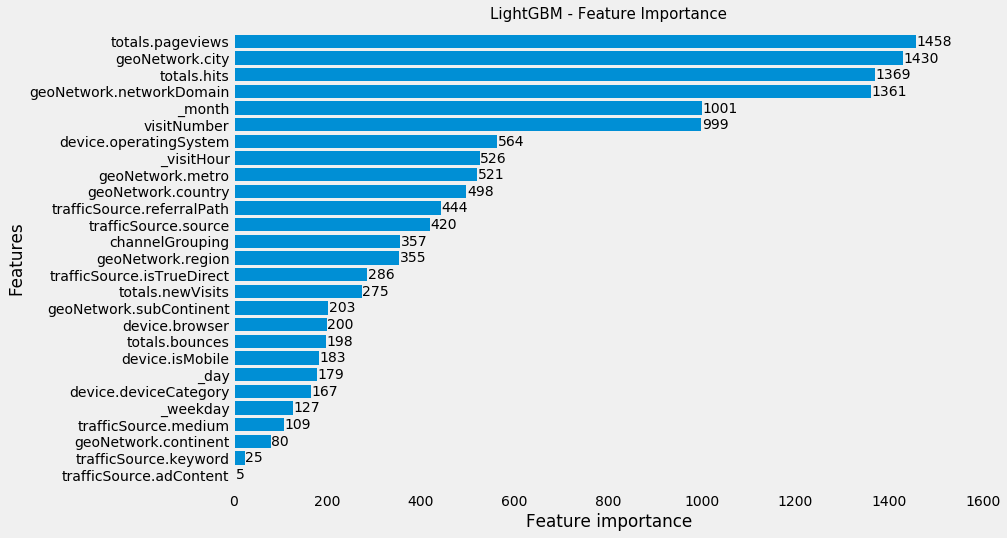

In [188]:
fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(lgb_model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()